In [2]:
!pip install yfinance

In [74]:
import yfinance as yf
df = yf.download('005930.KS','2020-11-30','2023-11-21')
df.reset_index(inplace = True)
print(df)

[*********************100%%**********************]  1 of 1 completed
          Date     Open     High      Low    Close     Adj Close    Volume
0   2020-11-30  68400.0  68600.0  66700.0  66700.0  61692.703125  43811016
1   2020-12-01  67100.0  68300.0  67100.0  67800.0  62710.117188  22327173
2   2020-12-02  68400.0  69900.0  68300.0  69500.0  64282.500000  29703942
3   2020-12-03  70100.0  70500.0  69300.0  69700.0  64467.468750  23677989
4   2020-12-04  70400.0  72100.0  70100.0  71500.0  66132.351562  28130533
..         ...      ...      ...      ...      ...           ...       ...
727 2023-11-14  71000.0  71100.0  70600.0  70800.0  70800.000000   9567984
728 2023-11-15  71600.0  72200.0  71500.0  72200.0  72200.000000  20148677
729 2023-11-16  72500.0  73000.0  72300.0  72800.0  72800.000000  15860451
730 2023-11-17  72300.0  73000.0  72300.0  72500.0  72500.000000  11494644
731 2023-11-20  72100.0  73000.0  72100.0  72700.0  72700.000000  10610157

[732 rows x 7 columns]


In [75]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 3                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Common functions

In [76]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1

    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))

    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list

    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days),
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std

    row_scaled = (row-feat_mean) / feat_std

    return row_scaled

def get_mape(y_true, y_pred):
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              :
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)

    # Train the model
    model.fit(X_train_scaled, y_train_scaled)

    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)

    return rmse, mape, est

# Load data

In [77]:
df = yf.download('005930.KS','2020-11-30','2023-11-21')

df.reset_index(inplace = True)

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

[*********************100%%**********************]  1 of 1 completed


<ipython-input-77-8dc129f57ae6>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')


,date,open,high,low,close,adj_close,volume,month
0,2020-11-30,68400.0,68600.0,66700.0,66700.0,61692.703125,43811016,11
1,2020-12-01,67100.0,68300.0,67100.0,67800.0,62710.132812,22327173,12
2,2020-12-02,68400.0,69900.0,68300.0,69500.0,64282.500000,29703942,12
3,2020-12-03,70100.0,70500.0,69300.0,69700.0,64467.492188,23677989,12
4,2020-12-04,70400.0,72100.0,70100.0,71500.0,66132.343750,28130533,12


Text(0, 0.5, 'Won')

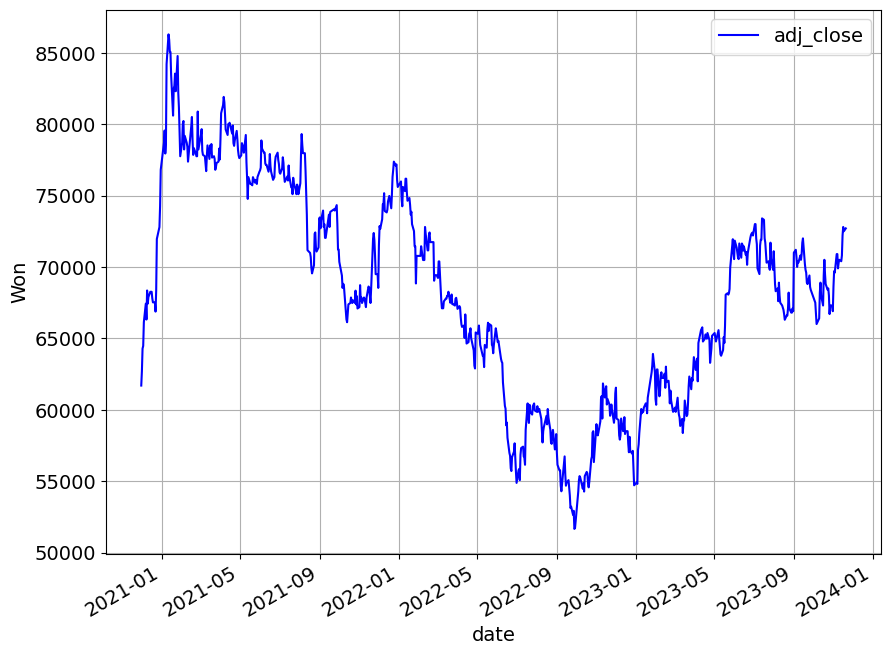

In [78]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("Won")

# Feature Engineering

We will generate the following features:
* Mean 'adj_close' of each month
* Difference between high and low of each day
* Difference between open and close of each day
* Mean volume of each month

In [79]:
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)

df.head()

,date,adj_close,volume,month,range_hl,range_oc
0,2020-11-30,61692.703125,43811016,11,1900.0,1700.0
1,2020-12-01,62710.132812,22327173,12,1200.0,-700.0
2,2020-12-02,64282.500000,29703942,12,1600.0,-1100.0
3,2020-12-03,64467.492188,23677989,12,1200.0,400.0
4,2020-12-04,66132.343750,28130533,12,2000.0,-1100.0


Now we use lags up to N number of days to use as features.

In [80]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']
lag_cols

['adj_close', 'range_hl', 'range_oc', 'volume']

In [81]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()

    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift

    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)

del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]

df.head()

<ipython-input-81-8d3c577bf558>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for shift in tqdm_notebook(shift_range):


  0%|          | 0/3 [00:00<?, ?it/s]

,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3
3,2020-12-03,64467.492188,23677989,12,1200.0,400.0,3,64282.500000,1600.0,-1100.0,29703942.0,62710.132812,1200.0,-700.0,22327173.0,61692.703125,1900.0,1700.0,43811016.0
4,2020-12-04,66132.343750,28130533,12,2000.0,-1100.0,4,64467.492188,1200.0,400.0,23677989.0,64282.500000,1600.0,-1100.0,29703942.0,62710.132812,1200.0,-700.0,22327173.0
5,2020-12-07,67427.257812,28490496,12,1600.0,-500.0,5,66132.343750,2000.0,-1100.0,28130533.0,64467.492188,1200.0,400.0,23677989.0,64282.500000,1600.0,-1100.0,29703942.0
6,2020-12-08,66317.335938,25000338,12,1300.0,500.0,6,67427.257812,1600.0,-500.0,28490496.0,66132.343750,2000.0,-1100.0,28130533.0,64467.492188,1200.0,400.0,23677989.0
7,2020-12-09,68352.187500,24077996,12,1900.0,-1800.0,7,66317.335938,1300.0,500.0,25000338.0,67427.257812,1600.0,-500.0,28490496.0,66132.343750,2000.0,-1100.0,28130533.0


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 729 entries, 3 to 731
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             729 non-null    datetime64[ns]
 1   adj_close        729 non-null    float64       
 2   volume           729 non-null    int64         
 3   month            729 non-null    int64         
 4   range_hl         729 non-null    float64       
 5   range_oc         729 non-null    float64       
 6   order_day        729 non-null    int64         
 7   adj_close_lag_1  729 non-null    float64       
 8   range_hl_lag_1   729 non-null    float64       
 9   range_oc_lag_1   729 non-null    float64       
 10  volume_lag_1     729 non-null    float64       
 11  adj_close_lag_2  729 non-null    float64       
 12  range_hl_lag_2   729 non-null    float64       
 13  range_oc_lag_2   729 non-null    float64       
 14  volume_lag_2     729 non-null    float64  

In [83]:
# # Get mean of adj_close of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'adj_close':'mean'})
# df_gb = df_gb.rename(columns={'adj_close':'adj_close_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb,
#               left_on=['month'],
#               right_on=['month'],
#               how='left').fillna(0)

# # Merge to main df
# shift_range = [x+1 for x in range(2)]

# for shift in tqdm_notebook(shift_range):
#     train_shift = df[merging_keys + lag_cols].copy()

#     # E.g. order_day of 0 becomes 1, for shift = 1.
#     # So when this is merged with order_day of 1 in df, this will represent lag of 1.
#     train_shift['order_day'] = train_shift['order_day'] + shift

#     foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
#     train_shift = train_shift.rename(columns=foo)

#     df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)

# del train_shift

# df

In [84]:
# # Get mean of volume of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'volume':'mean'})
# df_gb = df_gb.rename(columns={'volume':'volume_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb,
#               left_on=['month'],
#               right_on=['month'],
#               how='left').fillna(0)

# df.head()

# Get mean and std dev at timestamp t using values from t-1, ..., t-N

In [85]:
cols_list = [
"adj_close",
"range_hl",
"range_oc",
"volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
3,2020-12-03,64467.492188,23677989,12,1200.0,400.0,3,64282.500000,1600.0,-1100.0,...,1700.0,43811016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-12-04,66132.343750,28130533,12,2000.0,-1100.0,4,64467.492188,1200.0,400.0,...,-700.0,22327173.0,64467.492188,NaN,1200.000000,NaN,400.000000,NaN,2.367799e+07,NaN
5,2020-12-07,67427.257812,28490496,12,1600.0,-500.0,5,66132.343750,2000.0,-1100.0,...,-1100.0,29703942.0,65299.917969,1177.227830,1600.000000,565.685425,-350.000000,1060.660172,2.590426e+07,3.148424e+06
6,2020-12-08,66317.335938,25000338,12,1300.0,500.0,6,67427.257812,1600.0,-500.0,...,400.0,23677989.0,66009.031250,1483.730979,1600.000000,400.000000,-400.000000,754.983444,2.676634e+07,2.680639e+06
7,2020-12-09,68352.187500,24077996,12,1900.0,-1800.0,7,66317.335938,1300.0,500.0,...,-1100.0,28130533.0,66625.645833,700.351234,1633.333333,351.188458,-366.666667,808.290377,2.720712e+07,1.919587e+06


# Split into train, dev and test set

In [86]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 439
num_cv = 145
num_test = 145
train.shape = (439, 27)
cv.shape = (145, 27)
train_cv.shape = (584, 27)
test.shape = (145, 27)


# Scale the train, dev and test set

In [87]:
cols_to_scale = [
"adj_close"
]

for i in range(1,N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [7.08136644e+04 7.08350905e+04 1.20546697e+03 6.76537585e+01
 1.71799001e+07 7.08533797e+04 1.20569476e+03 6.37813212e+01
 1.72041879e+07 7.08675719e+04 1.20751708e+03 6.90205011e+01
 1.72754546e+07]
scaler.var_ = [5.46383671e+07 5.41564980e+07 6.10402914e+05 7.51573311e+05
 7.69786744e+13 5.37121208e+07 6.10377592e+05 7.50920554e+05
 7.69691512e+13 5.33634752e+07 6.11446910e+05 7.55987879e+05
 7.85267787e+13]
train_scaled.shape = (439, 13)
train_scaled.shape = (439, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-0.858545,-0.890405,0.504981,-1.346878,1.427445,-1.111121,-0.007289,-0.881398,0.583935,-1.255966,0.885584,1.875820,2.994466,2020-12-03,12
1,-0.633315,-0.865267,-0.006997,0.383358,0.740629,-0.896577,0.504700,-1.342995,1.424765,-1.116688,-0.009613,-0.884465,0.570073,2020-12-04,12
2,-0.458132,-0.639037,1.016959,-1.346878,1.248113,-0.871335,-0.007289,0.387994,0.737906,-0.901443,0.501928,-1.344512,1.402521,2020-12-07,12
3,-0.608288,-0.463077,0.504981,-0.654784,1.289141,-0.644171,1.016689,-1.342995,1.245422,-0.876119,-0.009613,0.380666,0.722509,2020-12-08,12
4,-0.333002,-0.613900,0.120997,0.498708,0.891345,-0.467484,0.504700,-0.650599,1.286452,-0.648215,1.013469,-1.344512,1.224966,2020-12-09,12


In [88]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [6.79622611e+04 6.79610740e+04 1.16695205e+03 5.95890411e+01
 1.57840096e+07 6.79575353e+04 1.16626712e+03 5.58219178e+01
 1.57945416e+07 6.79505506e+04 1.16832192e+03 5.95890411e+01
 1.58437197e+07]
scaler_train_cv.var_ = [6.80828056e+07 6.80907175e+07 5.07692080e+05 6.94531338e+05
 7.31216901e+13 6.81205549e+07 5.07372367e+05 6.91952407e+05
 7.31946253e+13 6.81795311e+07 5.07917732e+05 6.96038187e+05
 7.45354053e+13]
train_cv_scaled.shape = (584, 13)
train_cv_scaled.shape = (584, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-0.423545,-0.445795,0.607765,-1.391420,1.627849,-0.635778,0.047358,-0.908618,0.763569,-0.757876,1.026652,1.966238,3.239434,2020-12-03,12
1,-0.221775,-0.423377,0.046381,0.408468,0.923151,-0.445269,0.608918,-1.389482,1.625806,-0.634657,0.044449,-0.910463,0.750974,2020-12-04,12
2,-0.064839,-0.221618,1.169149,-1.391420,1.443848,-0.422855,0.047358,0.413757,0.921460,-0.444230,0.605708,-1.389913,1.605421,2020-12-07,12
3,-0.199355,-0.064692,0.607765,-0.671465,1.485944,-0.221141,1.170479,-1.389482,1.441898,-0.421826,0.044449,0.408025,0.907438,2020-12-08,12
4,0.047257,-0.199200,0.186727,0.528460,1.077792,-0.064249,0.608918,-0.668186,1.483972,-0.220199,1.166967,-1.389913,1.423174,2020-12-09,12


In [89]:
# Do scaling for dev set
cv_scaled = cv[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)

# Now the entire dev set is scaled
cv_scaled.head()

<ipython-input-89-7c20de4c3c09>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(cols_list):


  0%|          | 0/4 [00:00<?, ?it/s]

,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
442,2022-09-19,-0.320258,-0.800640,1.120897,-1.154701,0.577350,0.577350,-0.577350,1.154701,-0.577350,1.013016,-0.986455,-0.026560
443,2022-09-20,1.000000,0.000000,-1.000000,0.000000,-1.000000,1.000000,-0.244339,-0.855186,1.099525,-0.206482,1.087123,-0.880641
444,2022-09-21,-1.091089,0.872872,0.218218,1.091089,-0.218218,-0.872872,1.050702,-0.110600,-0.940102,0.871609,-1.091718,0.220109
445,2022-09-22,-0.968365,-0.060520,1.028886,-1.109400,0.832050,0.277350,-0.277350,1.109400,-0.832050,-0.747410,1.135961,-0.388551
446,2022-09-23,-1.080633,0.187934,0.892699,-0.688247,-0.458831,1.147079,-0.377964,-0.755929,1.133893,-0.101286,-0.945503,1.046788


In [90]:
# Do scaling for test set
test_scaled = test[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)

# Now the entire test set is scaled
test_scaled.head()

<ipython-input-90-3606b466347d>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(cols_list):


  0%|          | 0/4 [00:00<?, ?it/s]

,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
587,2023-04-18,-0.377964,-0.755930,1.133893,-0.352673,1.128553,-0.775880,-0.484182,1.149932,-0.665750,-1.057766,0.929942,0.127824
588,2023-04-19,1.059626,-0.132453,-0.927173,-0.094916,-0.949158,1.044074,-0.218218,-0.872872,1.091089,-0.014619,-0.992611,1.007229
589,2023-04-20,0.218218,0.872872,-1.091089,-1.044074,0.949158,0.094916,0.000000,1.000000,-1.000000,-1.108121,0.835221,0.272900
590,2023-04-21,-1.091089,0.218218,0.872872,-0.277350,-0.832050,1.109400,-0.927173,-0.132453,1.059626,-0.703943,-0.440713,1.144656
591,2023-04-24,1.000000,-1.000000,0.000000,-0.577350,1.154701,-0.577350,0.872872,-1.091089,0.218218,0.820437,-1.113896,0.293460


# Split into X and y

In [91]:
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (439, 12)
y_train.shape = (439,)
X_cv.shape = (145, 12)
y_cv.shape = (145,)
X_train_cv.shape = (584, 12)
y_train_cv.shape = (584,)
X_sample.shape = (145, 12)
y_sample.shape = (145,)


In [92]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (439, 12)
y_train_scaled.shape = (439,)
X_cv_scaled.shape = (145, 12)
X_train_cv_scaled.shape = (584, 12)
y_train_cv_scaled.shape = (584,)
X_sample_scaled.shape = (145, 12)


# EDA

Text(0.5, 1.0, 'Without scaling')

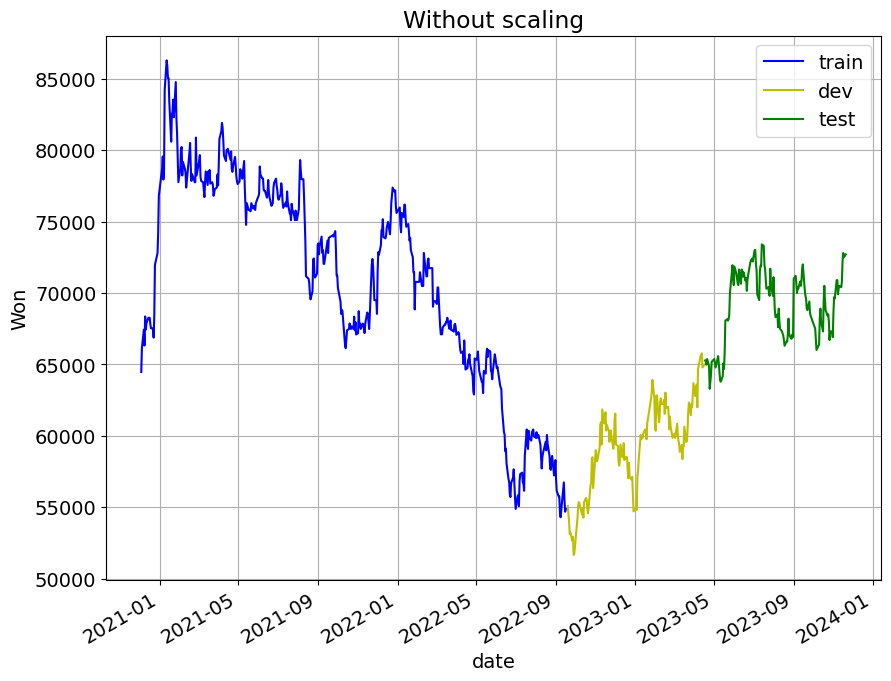

In [93]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("Won")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

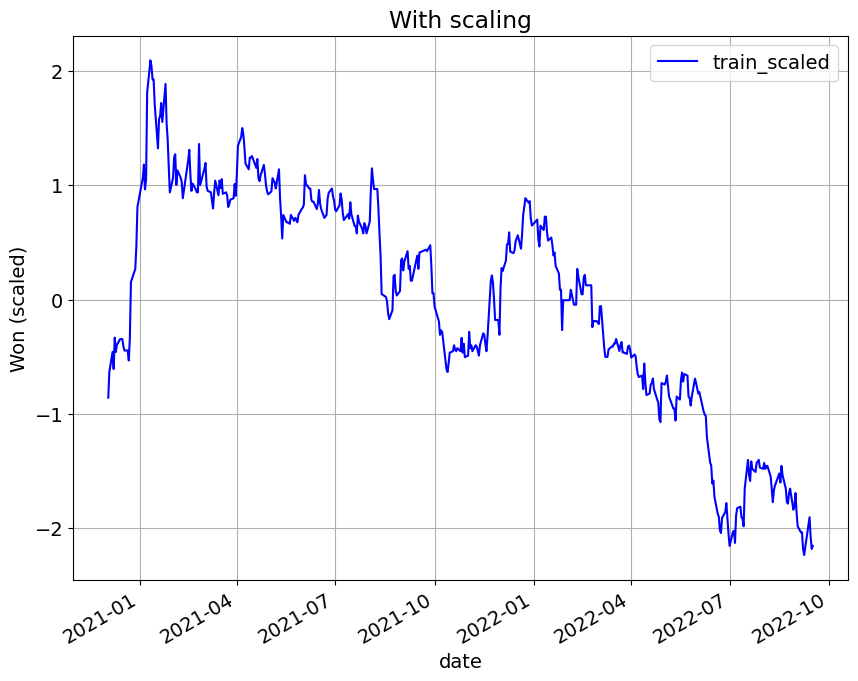

In [94]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_scaled.plot(x='date', y='adj_close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("Won (scaled)")
ax.set_title("With scaling")

# Train the model using XGBoost

In [95]:
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)

# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None, colsample_bylevel=1,
             colsample_bynode=None, colsample_bytree=1, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

# Predict on train set

In [96]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 603.594
MAPE on train set = 0.648%


Text(0.5, 1.0, 'Without scaling')

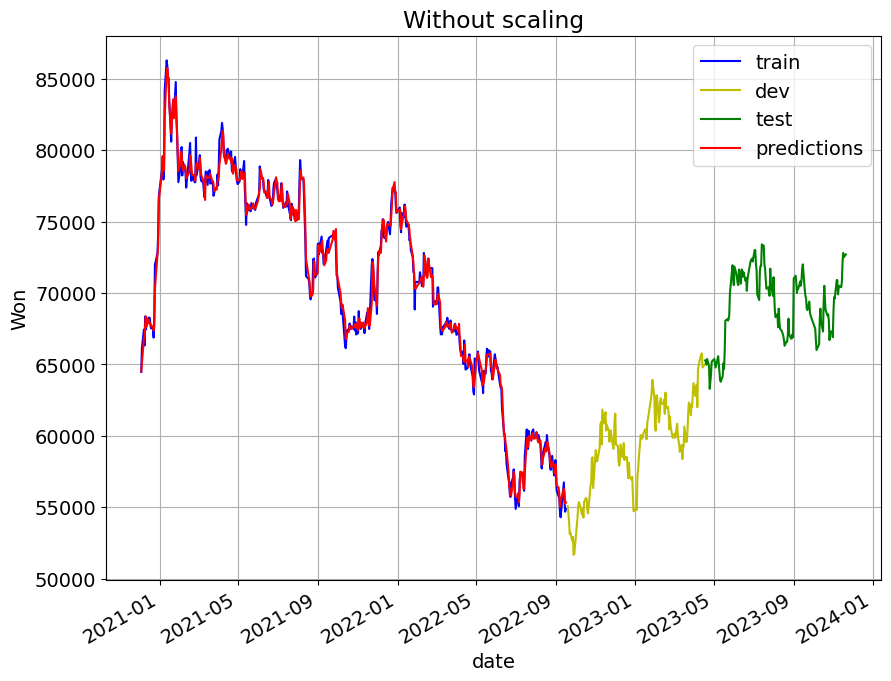

In [97]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est,
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("Won")
ax.set_title('Without scaling')

# Predict on dev set

In [98]:
# Do prediction on test set
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 952.189
MAPE on dev set = 1.249%


<ipython-input-98-2191fa052402>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['est_scaled'] = est_scaled
<ipython-input-98-2191fa052402>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']


Text(0, 0.5, 'Won')

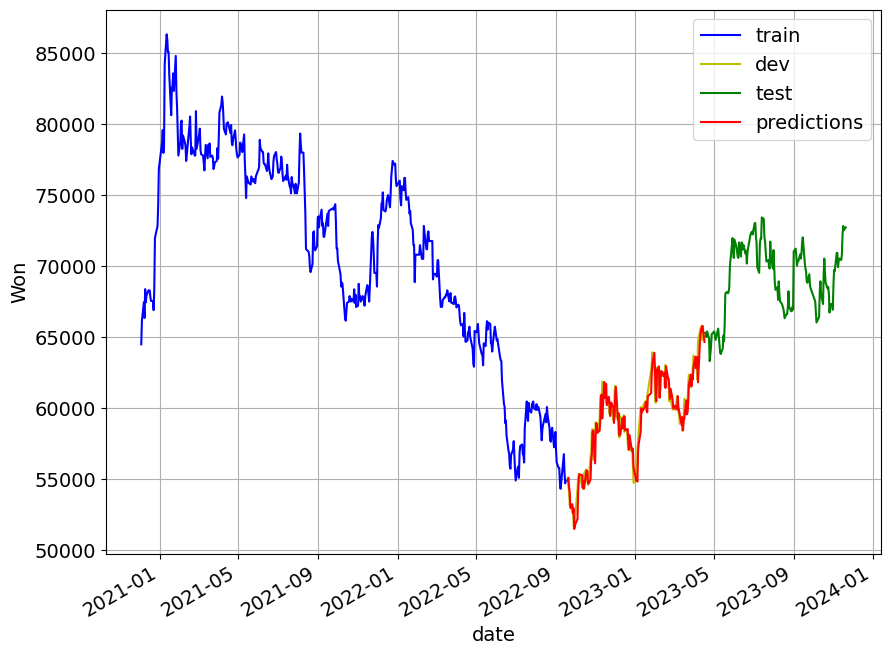

In [99]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'],
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("Won")

Text(0.5, 1.0, 'Zoom in to dev set')

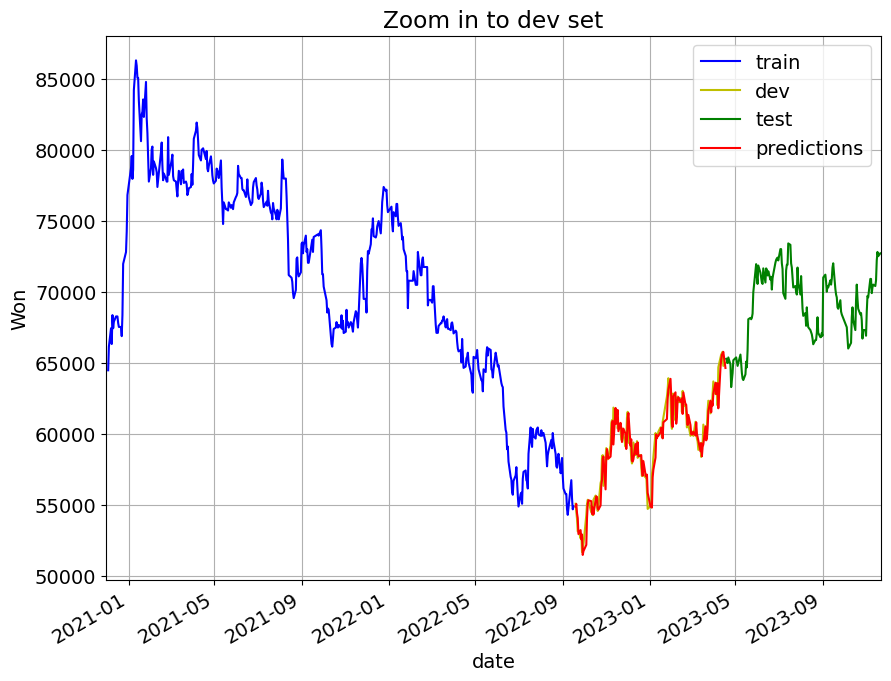

In [100]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("Won") #'2020-11-30','2023-11-21'
ax.set_xlim([date(2020, 11, 30), date(2023, 11, 21)])
ax.set_title("Zoom in to dev set")

The predictions capture the turn in directions with a slight lag

In [101]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1])
imp[-10:]

[('range_hl_lag_2', 0.0031924832),
 ('range_hl_lag_3', 0.003257067),
 ('range_oc_lag_3', 0.003529176),
 ('volume_lag_3', 0.004232456),
 ('range_hl_lag_1', 0.0053723822),
 ('volume_lag_1', 0.006096856),
 ('volume_lag_2', 0.008939443),
 ('adj_close_lag_2', 0.012790549),
 ('adj_close_lag_3', 0.017468002),
 ('adj_close_lag_1', 0.93047065)]

Importance features dominated by adj_close and volume

# Tuning N (no. of days to use as features)

In [102]:
d = {'N': [2, 3, 4, 5, 6, 7, 14],
     'rmse_dev_set': [1.225, 1.214, 1.231, 1.249, 1.254, 1.251, 1.498],
     'mape_pct_dev_set': [0.585, 0.581, 0.590, 0.601, 0.609, 0.612, 0.763]}
pd.DataFrame(d)

,N,rmse_dev_set,mape_pct_dev_set
0,2,1.225,0.585
1,3,1.214,0.581
2,4,1.231,0.590
3,5,1.249,0.601
4,6,1.254,0.609
5,7,1.251,0.612
6,14,1.498,0.763


Use N = 3 for lowest RMSE and MAPE

# Tuning XGBoost - n_estimators (default=100) and max_depth (default=3)

In [103]:
param_label = 'n_estimators'
param_list = range(10, 310, 10)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))

    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled,
                                     y_train_scaled,
                                     X_cv_scaled,
                                     y_cv,
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=param,
                                     max_depth=param2,
                                     learning_rate=learning_rate,
                                     min_child_weight=min_child_weight,
                                     subsample=subsample,
                                     colsample_bytree=colsample_bytree,
                                     colsample_bylevel=colsample_bylevel,
                                     gamma=gamma)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)

error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

<ipython-input-103-979a10c85647>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/30 [00:00<?, ?it/s]

Minutes taken = 1.1460986216862996


,n_estimators,max_depth,rmse,mape_pct
0,10,2,943.738018,1.255120
1,10,3,941.616340,1.251860
2,10,4,941.856853,1.252387
3,10,5,941.500339,1.250085
4,10,6,941.635439,1.251046
...,...,...,...,...
235,300,5,948.128496,1.241521
236,300,6,941.792815,1.231543
237,300,7,947.601598,1.235932
238,300,8,949.245342,1.237503


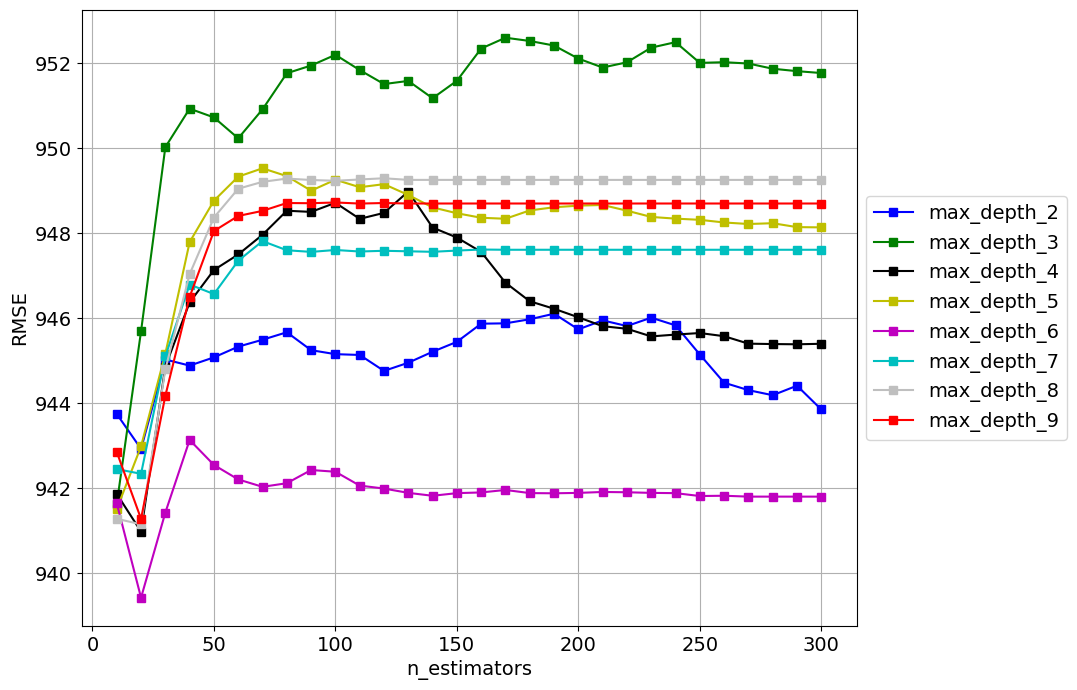

In [104]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [105]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 939.414
optimum params = 


(20, 6)

In [106]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 1.232%
optimum params = 


(300, 6)

# Tuning XGBoost - learning_rate(default=0.1) and min_child_weight(default=1)

In [107]:
param_label = 'learning_rate'
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))

    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled,
                                     y_train_scaled,
                                     X_cv_scaled,
                                     y_cv,
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt,
                                     max_depth=max_depth_opt,
                                     learning_rate=param,
                                     min_child_weight=param2,
                                     subsample=subsample,
                                     colsample_bytree=colsample_bytree,
                                     colsample_bylevel=colsample_bylevel,
                                     gamma=gamma)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)

error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

<ipython-input-107-7b16e04ad84d>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/7 [00:00<?, ?it/s]

Minutes taken = 0.059013533592224124


,learning_rate,min_child_weight,rmse,mape_pct
0,0.001,5,1055.342998,1.418931
1,0.001,6,1055.351424,1.418960
2,0.001,7,1055.351424,1.418960
3,0.001,8,1055.356202,1.418969
4,0.001,9,1055.353686,1.418962
...,...,...,...,...
107,0.300,16,952.815190,1.249916
108,0.300,17,955.794042,1.253548
109,0.300,18,953.781624,1.251947
110,0.300,19,959.214898,1.256505


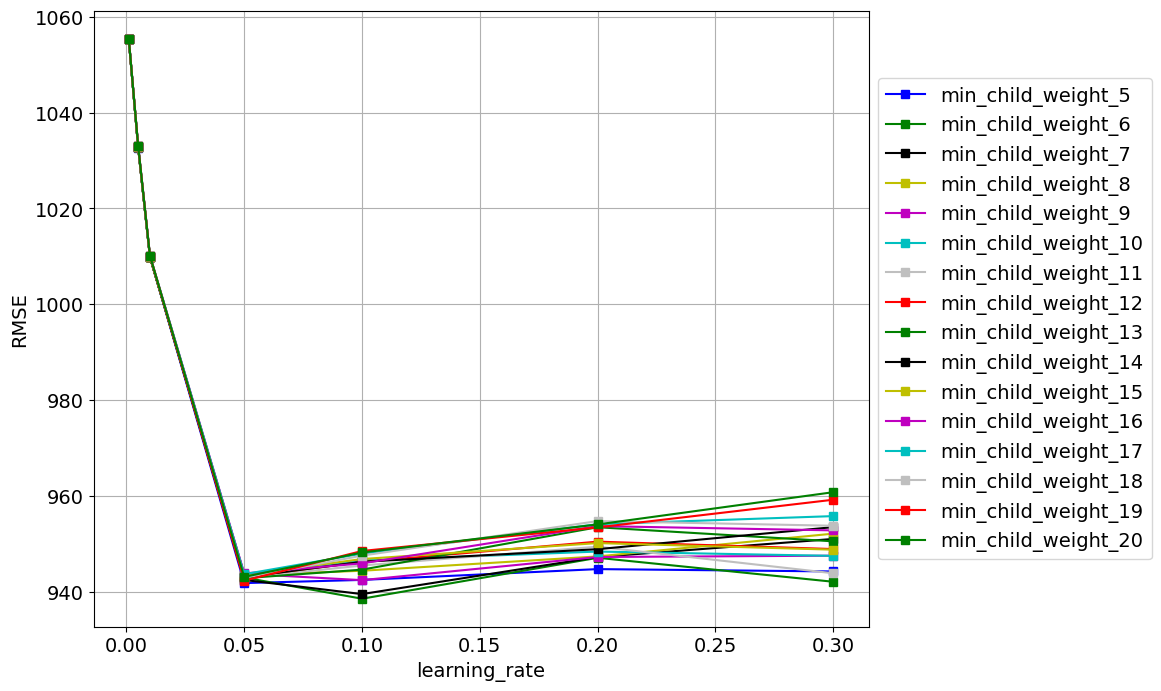

In [108]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [109]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 938.552
optimum params = 


(0.1, 6)

In [110]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 1.233%
optimum params = 


(0.3, 6)

# Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [111]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))

    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled,
                                     y_train_scaled,
                                     X_cv_scaled,
                                     y_cv,
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt,
                                     max_depth=max_depth_opt,
                                     learning_rate=learning_rate_opt,
                                     min_child_weight=min_child_weight_opt,
                                     subsample=param,
                                     colsample_bytree=colsample_bytree,
                                     colsample_bylevel=colsample_bylevel,
                                     gamma=param2)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)

error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

<ipython-input-111-d24fd31c8342>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/10 [00:00<?, ?it/s]

Minutes taken = 0.09288026094436645


,subsample,gamma,rmse,mape_pct
0,0.1,0.1,934.514185,1.247653
1,0.1,0.2,939.362218,1.255575
2,0.1,0.3,938.813359,1.248547
3,0.1,0.4,938.328611,1.248429
4,0.1,0.5,942.092284,1.255660
...,...,...,...,...
95,1.0,0.6,943.148911,1.241581
96,1.0,0.7,945.390600,1.243888
97,1.0,0.8,945.507791,1.244189
98,1.0,0.9,944.620636,1.242628


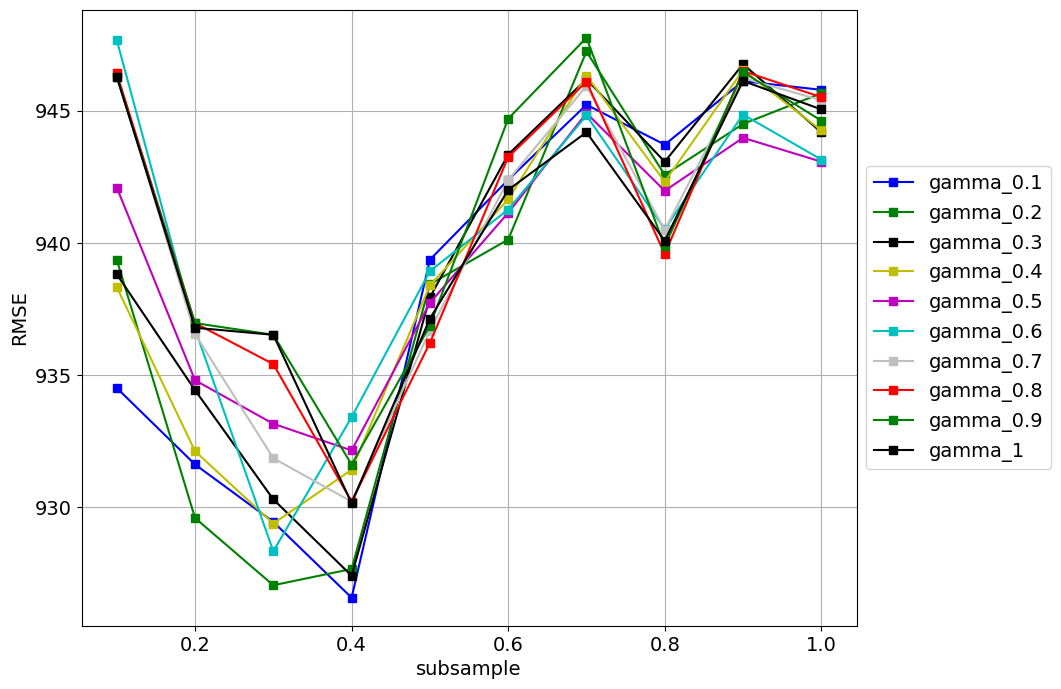

In [112]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [113]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 926.585
optimum params = 


(0.4, 0.1)

In [114]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 1.222%
optimum params = 


(0.4, 0.1)

# Tuning XGBoost - colsample_bytree(default=1) and colsample_bylevel(default=1)

In [115]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))

    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled,
                                     y_train_scaled,
                                     X_cv_scaled,
                                     y_cv,
                                     cv['adj_close_mean'],
                                     cv['adj_close_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt,
                                     max_depth=max_depth_opt,
                                     learning_rate=learning_rate_opt,
                                     min_child_weight=min_child_weight_opt,
                                     subsample=subsample_opt,
                                     colsample_bytree=param,
                                     colsample_bylevel=param2,
                                     gamma=gamma_opt)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)

error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

<ipython-input-115-3237aa3231fb>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(param_list):


  0%|          | 0/6 [00:00<?, ?it/s]

Minutes taken = 0.015614549318949381


,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,1048.656518,1.404744
1,0.5,0.6,1048.656518,1.404744
2,0.5,0.7,1024.111877,1.373666
3,0.5,0.8,1024.111877,1.373666
4,0.5,0.9,1007.823212,1.363173
5,0.5,1.0,981.640964,1.325040
6,0.6,0.5,1087.196703,1.448486
7,0.6,0.6,1017.662666,1.362566
8,0.6,0.7,1017.662666,1.362566
9,0.6,0.8,982.021310,1.317815


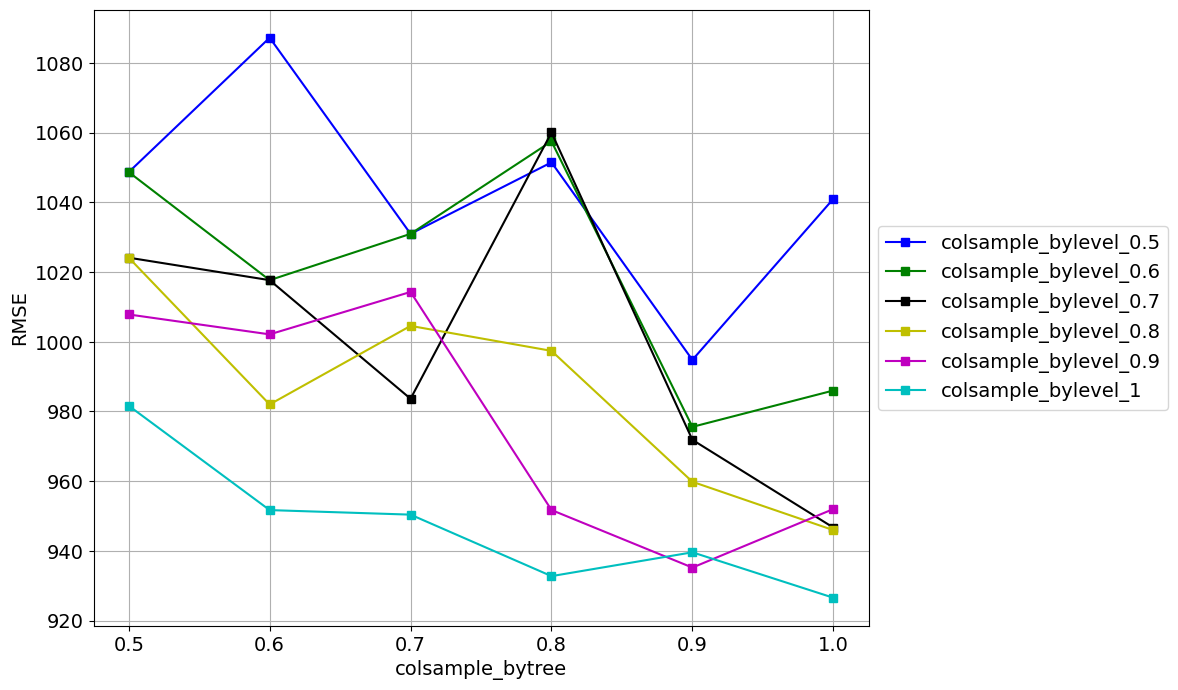

In [116]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [117]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 926.585
optimum params = 


(1.0, 1.0)

In [118]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 1.222%
optimum params = 


(1.0, 1.0)

# Tuned params

In [119]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,original,after_tuning
0,n_estimators,100.000,20.000
1,max_depth,3.000,6.000
2,learning_rate,0.100,0.100
3,min_child_weight,1.000,6.000
4,subsample,1.000,0.400
5,colsample_bytree,1.000,1.000
6,colsample_bylevel,1.000,1.000
7,gamma,0.000,0.100
8,rmse,952.189,926.585
9,mape_pct,1.249,1.222


# Final model

In [120]:
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled,
                             y_train_cv_scaled,
                             X_sample_scaled,
                             y_sample,
                             test['adj_close_mean'],
                             test['adj_close_std'],
                             seed=model_seed,
                             n_estimators=n_estimators_opt,
                             max_depth=max_depth_opt,
                             learning_rate=learning_rate_opt,
                             min_child_weight=min_child_weight_opt,
                             subsample=subsample_opt,
                             colsample_bytree=colsample_bytree_opt,
                             colsample_bylevel=colsample_bylevel_opt,
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 907.028
MAPE on test set = 0.998%


Text(0, 0.5, 'Won')

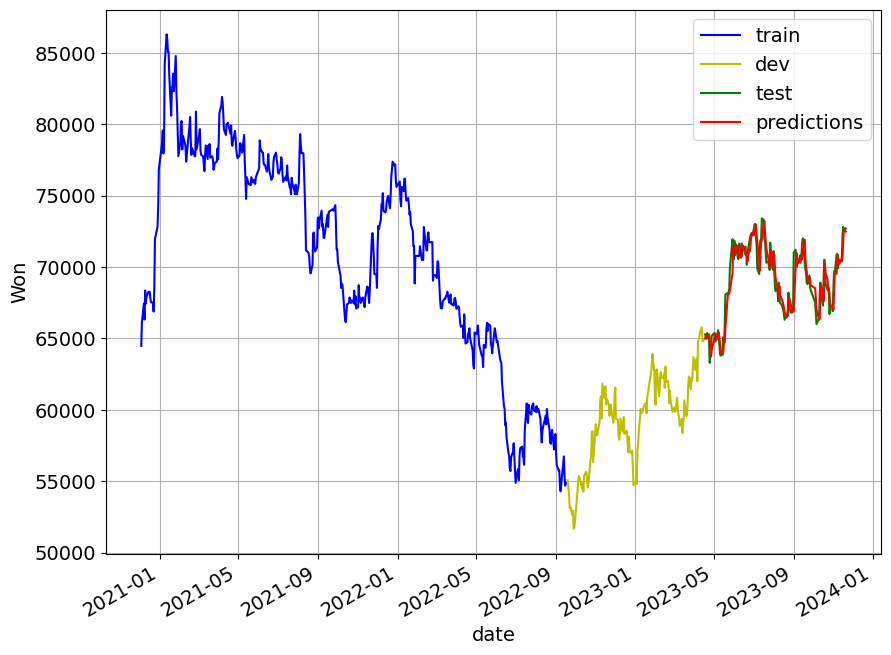

In [121]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est,
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("Won")

Similar to dev set, the predictions capture turns in direction with a slight lag